In [32]:
!pip install pandas 
!pip install scikit-learn==1.6.1
!pip install torch


In [44]:
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import statistics


In [45]:
# Get the current directory
current_directory = os.getcwd()
print(f"current directory: {current_directory}")

current directory: /Users/hayleyluo/Desktop/Github/ML-kaggle-projects/kaggle-ski-area-review


## Experiment #1 Use true label to train the model

In [46]:
# import the dataset
file_path = f'{current_directory}/datasets/bronze/on_the_snow_ski_area_reviews.csv'
df = pd.read_csv(file_path, header=0,index_col=0, sep=',', encoding='utf-8')
print(f"read dataset from {file_path}")     
df.info()

read dataset from /Users/hayleyluo/Desktop/Github/ML-kaggle-projects/kaggle-ski-area-review/datasets/bronze/on_the_snow_ski_area_reviews.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18250 entries, 0 to 18261
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   State                          18250 non-null  object
 1   Ski Area                       18250 non-null  object
 2   Reviewer Name                  18250 non-null  object
 3   Review Star Rating (out of 5)  18250 non-null  int64 
 4   Review Date datetime           18250 non-null  object
 5   Review Text Cleaned            18199 non-null  object
dtypes: int64(1), object(5)
memory usage: 998.0+ KB


In [47]:
df = df[~df["Review Text Cleaned"].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18199 entries, 0 to 18261
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   State                          18199 non-null  object
 1   Ski Area                       18199 non-null  object
 2   Reviewer Name                  18199 non-null  object
 3   Review Star Rating (out of 5)  18199 non-null  int64 
 4   Review Date datetime           18199 non-null  object
 5   Review Text Cleaned            18199 non-null  object
dtypes: int64(1), object(5)
memory usage: 995.3+ KB


In [49]:
# Preprocess labels
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df["Review Text Cleaned"].fillna("").tolist()).toarray()
df["Review Star Rating"] = df["Review Star Rating (out of 5)"]-1
y = df["Review Star Rating"].values
print("Vocabulary size:", len(vectorizer.vocabulary_))
print("TF-IDF matrix shape:", X.shape)
print("vectorizer.get_feature_names_out():", vectorizer.get_feature_names_out())


Vocabulary size: 5000
TF-IDF matrix shape: (18199, 5000)
vectorizer.get_feature_names_out(): ['06' '0607' '07' ... 'zone' 'zoo' 'zooming']


In [50]:
# class inbalance
print(df['Review Star Rating'].value_counts())


4    8615
3    4635
2    1932
0    1650
1    1367
Name: Review Star Rating, dtype: int64


In [53]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)

# Define MLP model: defining a custom PyTorch neural network class
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        """
        Arg:
        input_dim: the number of features, extracted via TF-IDF vectorizer
        """
        
        # calls the constructor of the parent nn.Module.
        super(SentimentClassifier, self).__init__()
        
        #build the neural network layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 5)  # 5 classes: positive & negative
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
model = SentimentClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
val_losses = []
train_losses = []
for epoch in range(epochs):
    step_loss = []
    # train the model with each epoch
    model.train()
    # Clear the gradients
    optimizer.zero_grad()
    # predict train set
    train_outputs = model(X_train)
    # calculate train loss 
    train_loss = criterion(train_outputs, y_train)
    step_loss.append(train_loss.item())
    # append the updated train loss every step
    train_losses.append(np.array(step_loss).mean())
    # Calculate gradients
    train_loss.backward()
    # Update Weights
    optimizer.step()

    # Validation
    model.eval()
    
    # disables gradient calculation
    with torch.no_grad():
         # predict X validation set
        val_outputs = model(X_val)
        # label validation prediction output based on the highest probability 
        val_preds = torch.argmax(val_outputs, dim=1)
        # calculate validation loss 
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
        accuracy = (val_preds == y_val).float().mean()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {val_loss.item():.4f} - Val Accuracy: {accuracy:.4f}")

Epoch 1/20 - Loss: 1.5968 - Val Accuracy: 0.2632
Epoch 2/20 - Loss: 1.5889 - Val Accuracy: 0.3099
Epoch 3/20 - Loss: 1.5801 - Val Accuracy: 0.4508
Epoch 4/20 - Loss: 1.5701 - Val Accuracy: 0.4624
Epoch 5/20 - Loss: 1.5586 - Val Accuracy: 0.4643
Epoch 6/20 - Loss: 1.5451 - Val Accuracy: 0.4643
Epoch 7/20 - Loss: 1.5292 - Val Accuracy: 0.4643
Epoch 8/20 - Loss: 1.5109 - Val Accuracy: 0.4643
Epoch 9/20 - Loss: 1.4906 - Val Accuracy: 0.4643
Epoch 10/20 - Loss: 1.4687 - Val Accuracy: 0.4643
Epoch 11/20 - Loss: 1.4464 - Val Accuracy: 0.4643
Epoch 12/20 - Loss: 1.4254 - Val Accuracy: 0.4643
Epoch 13/20 - Loss: 1.4077 - Val Accuracy: 0.4643
Epoch 14/20 - Loss: 1.3961 - Val Accuracy: 0.4643
Epoch 15/20 - Loss: 1.3923 - Val Accuracy: 0.4643
Epoch 16/20 - Loss: 1.3960 - Val Accuracy: 0.4643
Epoch 17/20 - Loss: 1.4036 - Val Accuracy: 0.4643
Epoch 18/20 - Loss: 1.4096 - Val Accuracy: 0.4643
Epoch 19/20 - Loss: 1.4104 - Val Accuracy: 0.4643
Epoch 20/20 - Loss: 1.4057 - Val Accuracy: 0.4643


<function matplotlib.pyplot.show(close=None, block=None)>

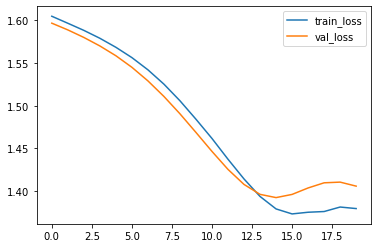

In [54]:
from matplotlib import pyplot as plt
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show

## Experiment #2 Use hugging face label to train the model

In [55]:
# import the dataset
file = f"{current_directory}/results/hugging_face_results.csv"
df = pd.read_csv(file, header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     18250 non-null  int64  
 1   Unnamed: 0.1                   18250 non-null  float64
 2   State                          18250 non-null  object 
 3   Ski Area                       18250 non-null  object 
 4   Reviewer Name                  18250 non-null  object 
 5   Review Date                    18250 non-null  object 
 6   Review Star Rating (out of 5)  18250 non-null  float64
 7   Review Text                    18250 non-null  object 
 8   Review Missing                 18126 non-null  float64
 9   Review Date datetime           18126 non-null  object 
 10  label                          18250 non-null  object 
 11  score                          18250 non-null  float64
 12  verdict                        18250 non-null 

In [ ]:
# Preprocess labels
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df["Review Text"].fillna("").tolist()).toarray()

# Preprocess labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])  # e.g., 'positive' -> 1, 'negative' -> 0
y = df["label_encoded"].values

print("Vocabulary size:", len(vectorizer.vocabulary_))
print("TF-IDF matrix shape:", X.shape)
print("vectorizer.get_feature_names_out():", vectorizer.get_feature_names_out())


Vocabulary size: 5000
TF-IDF matrix shape: (18250, 5000)
vectorizer.get_feature_names_out(): ['00' '000' '00am' ... 'zones' 'zoo' 'zooming']


In [ ]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Define MLP model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # Binary classification
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
model = SentimentClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
val_losses = []
train_losses = []
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y)
weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)

for epoch in range(epochs):
    step_loss = []
    # train the model with each epoch
    model.train()
    # Clear the gradients
    optimizer.zero_grad()
    # predict train set
    train_outputs = model(X_train)
    # calculate train loss 
    train_loss = criterion(train_outputs, y_train)
    step_loss.append(train_loss.item())
    # append the updated train loss every step
    train_losses.append(np.array(step_loss).mean())
    # Calculate gradients
    train_loss.backward()
    # Update Weights
    optimizer.step()

    # Validation
    model.eval()
    
    # disables gradient calculation
    with torch.no_grad():
         # predict X validation set
        val_outputs = model(X_val)
        # label validation prediction output based on the highest probability 
        val_preds = torch.argmax(val_outputs, dim=1)
        # calculate validation loss 
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
        accuracy = (val_preds == y_val).float().mean()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Val Accuracy: {accuracy:.4f}")

Epoch 1/20 - Loss: 1.5595 - Val Accuracy: 0.7003
Epoch 2/20 - Loss: 1.5595 - Val Accuracy: 0.7301
Epoch 3/20 - Loss: 1.5595 - Val Accuracy: 0.8099
Epoch 4/20 - Loss: 1.5595 - Val Accuracy: 0.7868
Epoch 5/20 - Loss: 1.5595 - Val Accuracy: 0.7781
Epoch 6/20 - Loss: 1.5595 - Val Accuracy: 0.7819
Epoch 7/20 - Loss: 1.5595 - Val Accuracy: 0.7877
Epoch 8/20 - Loss: 1.5595 - Val Accuracy: 0.7934
Epoch 9/20 - Loss: 1.5595 - Val Accuracy: 0.8000
Epoch 10/20 - Loss: 1.5595 - Val Accuracy: 0.8025
Epoch 11/20 - Loss: 1.5595 - Val Accuracy: 0.8016
Epoch 12/20 - Loss: 1.5595 - Val Accuracy: 0.8008
Epoch 13/20 - Loss: 1.5595 - Val Accuracy: 0.8008
Epoch 14/20 - Loss: 1.5595 - Val Accuracy: 0.8011
Epoch 15/20 - Loss: 1.5595 - Val Accuracy: 0.8027
Epoch 16/20 - Loss: 1.5595 - Val Accuracy: 0.8055
Epoch 17/20 - Loss: 1.5595 - Val Accuracy: 0.8093
Epoch 18/20 - Loss: 1.5595 - Val Accuracy: 0.8164
Epoch 19/20 - Loss: 1.5595 - Val Accuracy: 0.8181
Epoch 20/20 - Loss: 1.5595 - Val Accuracy: 0.8211


<function matplotlib.pyplot.show(close=None, block=None)>

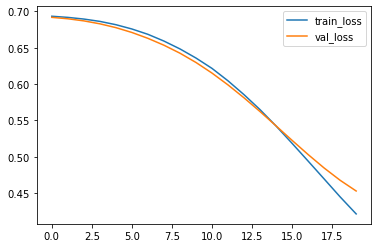

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show

In [ ]:
print(df['label'].value_counts())

POSITIVE    12728
NEGATIVE     5522
Name: label, dtype: int64
